# Breweries Pipeline
* Remove observations with '`NA`'
* Remove observations with Brewery Score of `0`
* Convert numeric values to `float`
* Convert categorical columns
    * Convert `Brewery_Type` to four new columns containing booleans for:
        * `Bar`
        * `Eatery`
        * `Homebrew`
        * `Beer-to-go`
* Create boolean from notes column indicating whether Brewery has notes
* Drop unnecessary columns
    * `Brewery_Notes`
    * `Brewery_Type`
    * `Brewery_Class`
    * `pDev` - this is the percent deviation of the scores i.e. results from the score and cannot be used as a predictor.

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as snsm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [2]:
os.chdir('Data2/')

# Breweries

In [3]:
brews_df = pd.read_pickle('breweries_with_loc')
brews_df.reset_index(inplace=True)
brews_df.columns = ['Brewery_Name','Score', 'Brewery_Class', 'Num_Beers', 
                    'Town', 'State', 'Country', 'Total_Beer_Reviews', 
                    'Total_Beer_Ratings', 'Brewery_Score', 
                    'Num_Brewery_Reviews', 'Num_Brewery_Ratings', 
                    'pDev', 'Brewery_Type', 'Has_Phone', 'Brewery_Notes']

##### Looking at our data

``` python 
i = 0 
while i < 15:
    print(brews_df.iloc[:,i].value_counts())
    i += 1 
    ```

### Removing rows with `'NA'` and `np.nan` values

This reduces the number of entries from 14,979 to 8,630. Close to a 50% reduction. While it is unfortunate to lose such a significant portion of a dataset, all of the observations that were removed did not contain a Brewery Score and thus would help in neither training nor testing of the model.

In [4]:
brews_df.replace('NA',np.nan,inplace=True)
brews_df.dropna(inplace=True)

### Removing rows with Score of zero

In addition to removing Breweries with no score, we've also removed Breweries with a score of zero as they were a clear outlier within the distribution. I believe that Breweries which have yet to receive any reviews either had no value ('NA') or a value of zero. This reduced the total number of Breweries in the dataset to 8153.

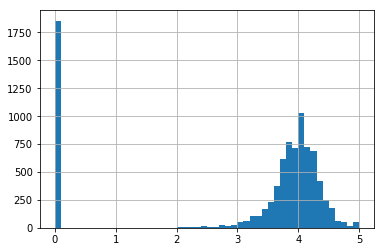

In [5]:
brews_df['Brewery_Score'] = brews_df['Brewery_Score'].apply(float)
brews_df['Brewery_Score'].hist(bins = 50);

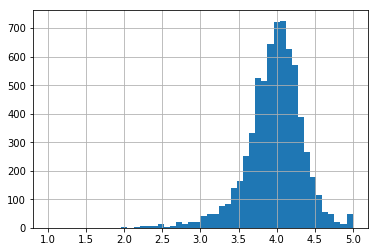

In [6]:
brews_df.Brewery_Score = brews_df.Brewery_Score.replace(0,np.nan)
brews_df.dropna(inplace=True)
brews_df['Brewery_Score'].hist(bins = 50);

### Convert remaining values to numeric where applicable

### Convert Categorical Columns

##### Convert b_type (Brewery Type) to dummies

The assumption in converting Brewery Type to dummies is that the functionality of the brewery, meaning whether one can eat there (i.e. is it also a restaurant) whether they have a bar, etc., may correlate to their score. It is also possible that the particular functionality might be irrelevant and that simply having greater functionality may boost the score (or even reduce it). In such a case we could take the sum of the newly created `'Bar'`, `'Eatery'`, `'Homebrew'`, and `'Beer-to-go'` columns.  
Note that we do not use `.get_dummies()` as it is possible for a brewery to be both a bar, eatery, etc. 

In [7]:
brews_df['Bar'] = brews_df.Brewery_Type.str.contains('Bar')
brews_df['Eatery'] = brews_df.Brewery_Type.str.contains('Eatery')
brews_df['Homebrew'] = brews_df.Brewery_Type.str.contains('Homebrew')
brews_df['Beer_to_go'] = brews_df.Brewery_Type.str.contains('Beer-to-go')

Creating a column containing a boolean value indicating whether a Brewery has notes on their brewery page within Beer Advocate. I believe this may have an impact on a Brewery's score as people may go onto a Brewery's page to research. Some Breweries may indicate hours (or days) of operation. Having a description can help reduce potential points of friction in a customer's relationship with a Brewery thus leading to the customer giving the Brewery a higher score.

In [8]:
brews_df['Has_Notes'] = brews_df.Brewery_Notes.str.contains('No notes at this time.')
brews_df.drop(['Brewery_Notes','Brewery_Type','Brewery_Class','pDev','Score'],inplace=True,axis=1)

Note that we'll leave the Brewery_Name column for now as it will be used to join the beer data with the brewery data.

### Convert column  types

In [9]:
brews_df.Brewery_Score = brews_df.Brewery_Score.apply(float)
brews_df.Num_Beers = brews_df.Num_Beers.apply(int)
brews_df.Total_Beer_Ratings = brews_df.Total_Beer_Ratings.apply(int)
brews_df.Total_Beer_Reviews = brews_df.Total_Beer_Reviews.apply(int)
brews_df.Num_Brewery_Ratings = brews_df.Num_Brewery_Ratings.apply(int)
brews_df.Num_Brewery_Reviews = brews_df.Num_Brewery_Reviews.apply(int)
brews_df.Has_Phone = brews_df.Has_Phone.astype(np.int32)
brews_df.Bar = brews_df.Bar.astype(np.int32)
brews_df.Eatery = brews_df.Eatery.astype(np.int32)
brews_df.Homebrew = brews_df.Homebrew.astype(np.int32)
brews_df.Beer_to_go = brews_df.Beer_to_go.astype(np.int32)
brews_df.Has_Notes = brews_df.Has_Notes.astype(np.int32)

### Sum of Brewery_Type columns
From this we can deduce whether there's a correlation between greater versatility at a brewery and their Score.

In [10]:
brews_df['Brewery_Style_Total'] = brews_df[['Bar','Eatery','Homebrew','Beer_to_go']].sum(axis=1)

### Plotting Correlations

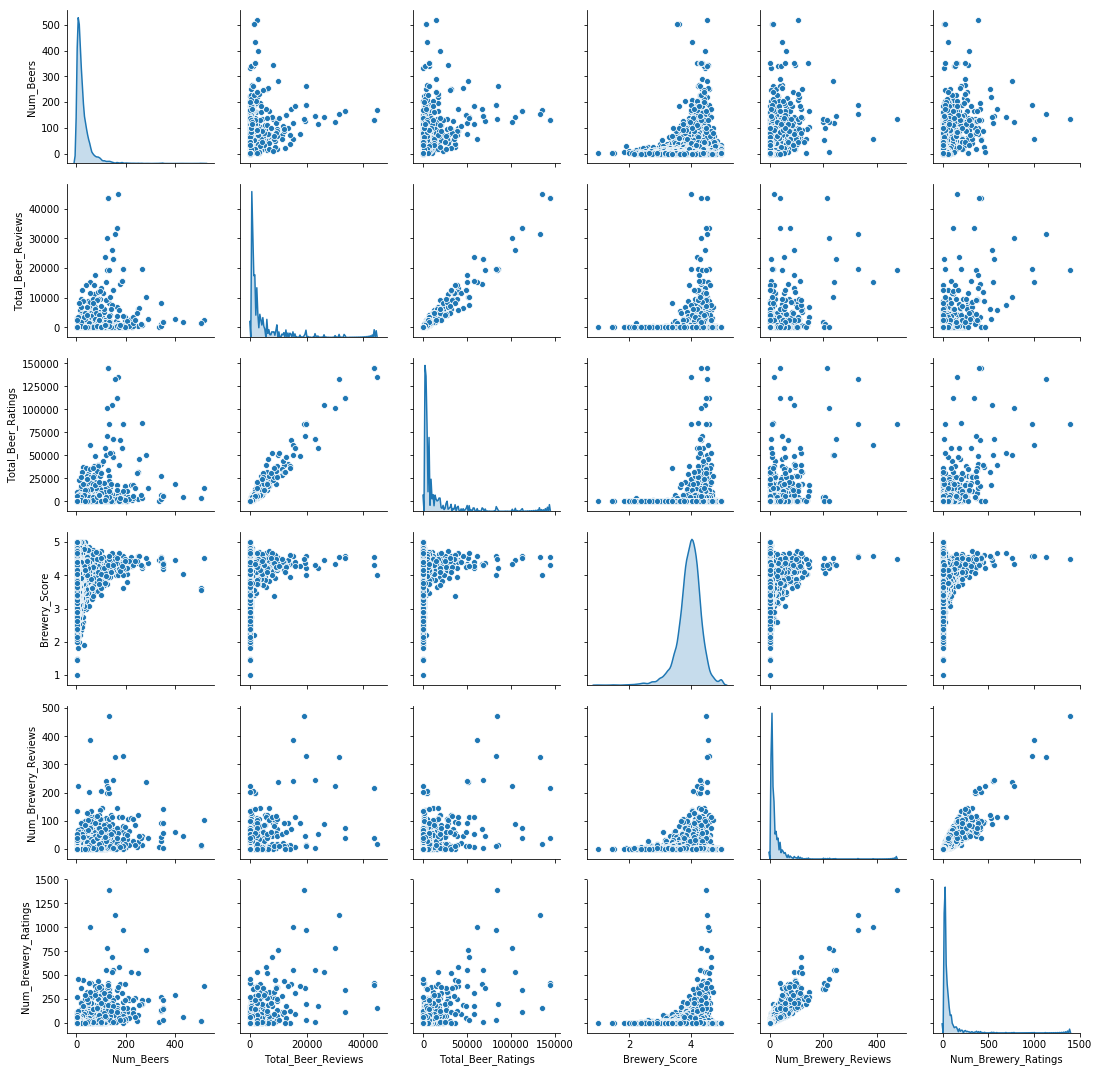

In [11]:
sns.pairplot(brews_df.iloc[:,0:10],diag_kind='kde');

In [12]:
brews_corr = brews_df.corr()

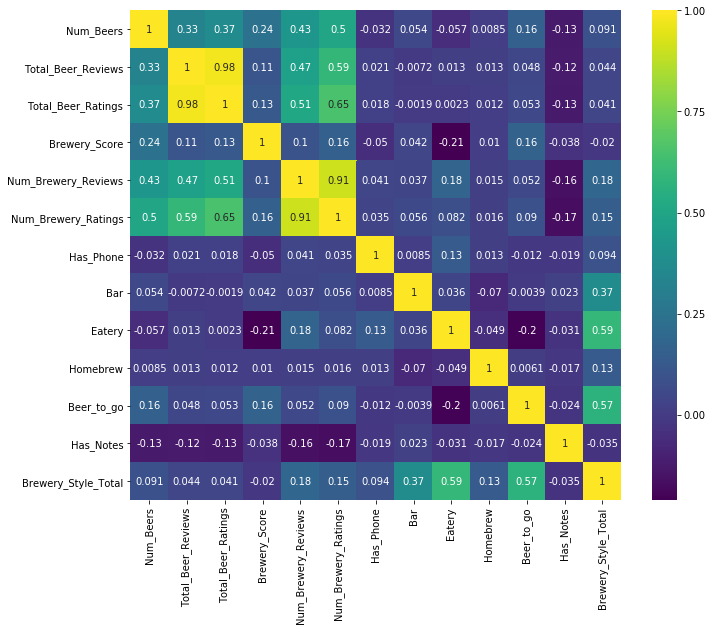

In [13]:
plt.figure(figsize=(11,9))
sns.heatmap(brews_corr,cmap='viridis',annot=True);

# NEEDS TO BE UPDATED

As you can see above, a Brewery's score is not impacted significantly by any of the characteristics listed on the Brewery's page on Beer Advocate. `Num_Beers` has the most significant correlation at `.23` but that is more a question of the Brewery's output/overall presense on beer advocate rather than a attribute of their profile. An attribute of their profile such as wether or not they include their phone number has almost zero correlation.   
The next most significant correlations are `Eatery`, `Num_Brewery_Ratings`, `Beer_to_go`, and `Bar` at only `-.15`, `.13`, `.13`, and `.12` respectively. From this we can tentatively assume that having a greater number of ratings for beers on Beer Advocate (although, note that it is not a critical component) and the ability to purchase beer-to-go (i.e. buy a 6-pack from a Brewery, not necessarily just drink at a bar within the brewery) will result in a slightly higher score, while serving food (`Eatery`) will lead to a lower score.  
Perhaps those who use Beer Advocate hold something against breweries that serve food?

### Drop weakest correlating Columns

In [14]:
reduced_corr_df = brews_corr[abs(brews_corr.Brewery_Score) < .1]
reduced_corr_df = reduced_corr_df.transpose()
drop_list = list(reduced_corr_df.columns)

In [15]:
print(drop_list)
brews_df.drop(drop_list,inplace=True,axis=1)

['Has_Phone', 'Bar', 'Homebrew', 'Has_Notes', 'Brewery_Style_Total']


### Testing whether strongest correlating columns are random

### Testing Geographic Correlations

### Assigning Brewery_Name to index

In [16]:
brews_df.set_index('Brewery_Name',inplace=True)

### Removing International Breweries

In [20]:
brews_df = brews_df[brews_df.Country == 'United States']

# Saving Clean Brewery Data

In [21]:
pd.to_pickle(brews_df,'Clean_Brewery_Data')